In [1]:
%matplotlib inline

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import os

In [3]:
os.chdir('/mnt/myParts/sda2/CollegeWork/Specialization/')

In [4]:
def showImage(img, title=None):
    plt.figure(figsize=(8,8))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.imshow(img)

In [5]:
# Input Color Image

img = cv2.imread('lenaColor1.png')[:,:,::-1]
ref = cv2.imread('bugsbunny.jpeg')[:,:,::-1]

In [6]:
# Encryption/Decryption Class

class imgEncDec:

    class __functions:
        def rotateRight(arr, r):
            return np.bitwise_or(np.right_shift(arr,r),np.left_shift(arr,8-r))
        def rotateLeft(arr, r):
            return np.bitwise_or(np.left_shift(arr,r),np.right_shift(arr,8-r))
        def xnor(arr,r):
            return np.bitwise_not(np.bitwise_xor(arr,r))
        def noop(arr,r):
            return arr
        def nott(arr,r):
            return np.bitwise_not(arr)

    def __init__(self, sKey):
        self.functionList = [(self.__functions.rotateRight,self.__functions.rotateLeft), (self.__functions.rotateLeft, self.__functions.rotateRight), (self.__functions.noop, self.__functions.noop), (np.bitwise_xor,np.bitwise_xor), (self.__functions.nott, self.__functions.nott), (self.__functions.xnor, self.__functions.xnor)]
        self.sKey = np.array([ord(c) for c in sKey])
        self.W, self.E = self.__genWE()

    def __genWE(self):
        temp = np.append(self.sKey,np.zeros(9-np.mod(len(self.sKey),9), dtype='uint8'))
        temp = temp.reshape(len(temp)//9,9)
        W = np.bitwise_xor.reduce(temp).astype(np.float128)/256
        temp = np.append(self.sKey,np.zeros(4-np.mod(len(self.sKey),4), dtype='uint8'))
        temp = temp.reshape(len(temp)//4,4)
        E = np.bitwise_xor.reduce(temp).astype(np.float128)/256
        E = 3.6+E/2.5
        return W,E

    # def __iterL4(self, c, itr=20):
    #     X = np.zeros(itr+1)
    #     X[0] = c
    #     for i in range(itr):
    #         xMul = X[i]*(1-X[i])
    #         L = np.multiply(self.E, xMul)
    #         res = np.ones(9)
    #         res[0] = L[0]
    #         res[0:2] = np.multiply(res[:2], L[:2])
    #         res[2:5] = np.multiply(res[:3], L[:3])
    #         res[5:] = np.multiply(res[2:6], L)
    #         X[i+1] = np.mod(self.E[0]*xMul + np.dot(res, self.W), 1)
    #     return X[1:]

    def __iterL4(self, c, itr=20):
        # X = np.zeros(itr+1)
        X = np.zeros(itr+1).astype(np.float128)
        X[0] = c
        LL = np.hstack((self.E[:2], self.E[:3], self.E))
        powr = np.array([2,1,3,2,1,4,3,2,1])
        for i in range(itr):
            xMul = X[i]*(1-X[i])
            res = np.power(np.multiply(LL, xMul), powr)
            X[i+1] = np.mod(self.E[0]*xMul + np.dot(res, self.W), 1)
        return X[1:]
    
    # def __iterL4XMap(self, rk, size, jobs=128):
    #     itr = jobs*13
    #     tSort = self.__iterL4(rk, itr)
    #     WW = np.stack([self.W[np.argsort(tSort[i:i+9])] for i in range(0,itr,13)])
    #     EE = np.stack([self.E[np.argsort(tSort[i+9:i+13])] for i in range(0,itr,13)])
    #     LL = np.hstack((EE[:,:2], EE[:,:3],EE))
    #     powr = np.array([2,1,3,2,1,4,3,2,1])
    #     # itr = int(np.ceil(size/jobs))
    #     # for i in range(itr):
    #     #     xMul = np.multiply(X[i*jobs:(i+1)*jobs],np.subtract(1,X[i*jobs:(i+1)*jobs]))
    #     #     res = np.power(np.multiply(LL, xMul.reshape(jobs,1)), powr)
    #     #     X[(i+1)*jobs:(i+2)*jobs] = np.mod(np.add(np.multiply(EE[:,0],xMul), np.sum(np.multiply(LL, WW), axis=1)),1)
    #     # return X[jobs:jobs+size]
        
    #     itr = size+size%jobs
    #     X=np.zeros(itr+jobs)
    #     X[:jobs]=rk
        
    #     for i in range(0,itr, jobs):
    #         xMul = np.multiply(X[i:i+jobs],np.subtract(1,X[i:i+jobs]))
    #         res = np.power(np.multiply(LL, xMul.reshape(jobs,1)), powr)
    #         X[i+jobs:i+2*jobs] = np.mod(np.add(np.multiply(EE[:,0],xMul), np.sum(np.multiply(res, WW), axis=1)),1)
    #     return X[jobs:jobs+size]
    
    def __iterL4XMap(self, rk, size, divs=64):
        # if divs < 4:
        #     return self.__iterL4(rk, size)
        tSort = self.__iterL4(rk, divs*13).reshape(divs, 13)
        WW = self.W[np.argsort(tSort[:,:9])]
        EE = self.E[np.argsort(tSort[:,9:13])]
        powr = np.array([2,1,3,2,1,4,3,2,1])
        LL = np.hstack((EE[:,:2], EE[:,:3],EE))
        
        itr = int(np.ceil(size/divs))
        # X = np.full(divs, rk)
        # XX = np.empty((itr, divs))
        X = np.full(divs, rk).astype(np.float128)
        XX = np.empty((itr, divs)).astype(np.float128)
        
        for i in range(itr):
            xMul = np.multiply(X,np.subtract(1,X))
            res = np.power(np.multiply(LL, xMul.reshape(divs,1)), powr)
            X = np.mod(np.add(np.multiply(EE[:,0],xMul), np.sum(np.multiply(res, WW), axis=1)),1)
            XX[i]=X
        return XX.ravel()[:size]

    def __genRK(self):
        RK = np.zeros(20).astype(np.float128)
        for c in self.sKey:
            RK += self.__iterL4(c/256,20)
        RK = RK%1
        return RK

    def __genXMap(self, rk, size):
        xMap = self.__iterL4(rk,size)
        # xMap = self.__iterL4XMap(rk, size, 1)
        return np.floor(xMap*255).astype('uint8')

    def __genPMap(self,xMap):
        # tempX = np.zeros(xMap.size).astype(np.int)
        # tempX[np.argsort(xMap)]=np.arange(xMap.size)
        # return tempX
        return np.argsort(xMap)

    def __genSMap(self, rk):
        sMap = self.__iterL4(rk,256)
        return np.argsort(sMap).astype('uint8')
    
    def __DFLGen(self, rk):
        temp = self.__iterL4(rk,6)
        temp = np.argsort(temp)
        return temp

    def exchanger(self, img):
        RK = self.__genRK()
        eImg = img.reshape(-1, img.shape[-1])
        xMap = self.__genXMap(RK[-1], eImg.shape[0])
        pMap = self.__genPMap(xMap)
        sMap = self.__genSMap(RK[-1])
        funcOrd = self.__DFLGen(RK[-1])
        eImg = eImg[pMap]
        eImg = sMap[eImg]
        eImg = np.bitwise_xor(eImg,xMap.reshape(xMap.shape[0],1))
        tempRK = np.round(RK).astype('uint8')
        for i in funcOrd:
            for rk in tempRK:
                eImg=self.functionList[i][0](eImg,rk)
        return eImg.reshape(img.shape).astype('uint8')

    def dexchanger(self, img):
        RK = self.__genRK()
        eImg = img.reshape(-1, img.shape[-1])
        xMap = self.__genXMap(RK[-1],eImg.shape[0])
        pMap = self.__genPMap(xMap)
        sMap = self.__genSMap(RK[-1])
        funcOrd = self.__DFLGen(RK[-1])[::-1]
        tempRK = np.round(RK).astype('uint8')
        for i in funcOrd:
            for rk in tempRK:
                eImg=self.functionList[i][1](eImg,rk)
        eImg = np.bitwise_xor(eImg,xMap.reshape(xMap.shape[0],1))
        nPMap = np.zeros_like(pMap)
        nSMap = np.zeros_like(sMap)
        for (i,t) in enumerate(pMap):
            nPMap[t] = i
        for (i,t) in enumerate(sMap):
            nSMap[t] = i
        eImg = nSMap[eImg]
        eImg = eImg[nPMap]
        return eImg.reshape(img.shape).astype('uint8')
    

In [7]:
# Hide/Unhide Class

class coverImage:
    def __init__(self):
        self.rmul = 252
        self.rhmul = 3
    def hideImg(self, img, ref):
        ref = cv2.resize(ref, (img.shape[0]*2, img.shape[1]*2))
        rs = ref.shape
        ref = np.bitwise_and(ref.reshape(-1, ref.shape[-1]), self.rmul)
        img = img.reshape(-1, img.shape[-1])
        ii = np.arange(img.shape[0])*4
        for i in range(3, 0, -1):
            ref[ii+i] = np.bitwise_or(ref[ii+i], np.bitwise_and(img, self.rhmul))
            img = np.right_shift(img, 2)
        ref[ii] = np.bitwise_or(ref[ii], np.bitwise_and(img, self.rhmul))
        return ref.reshape(rs)
    def unHideImg(self, img):
        rs = img.shape
        img = np.bitwise_and(img.reshape(-1,img.shape[-1]), self.rhmul)
        uImg = np.zeros((img.shape[0]//4, 3), dtype='uint8')
        ii = np.arange(uImg.shape[0])*4
        for i in range(3):
            uImg = np.bitwise_or(uImg, np.bitwise_and(img[ii+i], self.rhmul))
            uImg = np.left_shift(uImg, 2)
        uImg = np.bitwise_or(uImg, np.bitwise_and(img[ii+3], self.rhmul))
        return uImg.reshape((rs[0]//2, rs[1]//2, 3))

In [8]:
# Performing Encryption

sKey = 'This is a simple key'
etBegin = time.time()
eedClass = imgEncDec(sKey)
eImg = eedClass.exchanger(img)
etEnd = time.time()
htBegin = time.time()
ehuClass = coverImage()
ehImg = ehuClass.hideImg(eImg, ref)
htEnd = time.time()

In [9]:
# Performing Decryption

utBegin = time.time()
dhuClass = coverImage()
dhImg = dhuClass.unHideImg(ehImg)
utEnd = time.time()
dtBegin = time.time()
dedClass = imgEncDec(sKey)
dImg = dedClass.dexchanger(dhImg)
dtEnd = time.time()

In [10]:
# The time taken

print(f"{'Encryption Time':21} : {etEnd - etBegin}\n{'Hiding Time':21} : {htEnd - htBegin}\n{'Unhiding Time':21} : {utEnd - utBegin}\n{'Decryption Time':21} : {dtEnd - dtBegin}\n{'-'*50}\n{'Total Encryption Time':21} : {htEnd - htBegin + etEnd - etBegin}\n{'Total Decryption Time':21} : {utEnd - utBegin + dtEnd - dtBegin}\n{'-'*50}\n{'Total Time':21} : {etEnd - etBegin + htEnd - htBegin + utEnd - utBegin + dtEnd - dtBegin}")

Encryption Time       : 6.9787633419036865
Hiding Time           : 0.07958650588989258
Unhiding Time         : 0.05696678161621094
Decryption Time       : 5.1154680252075195
--------------------------------------------------
Total Encryption Time : 7.058349847793579
Total Decryption Time : 5.1724348068237305
--------------------------------------------------
Total Time            : 12.23078465461731


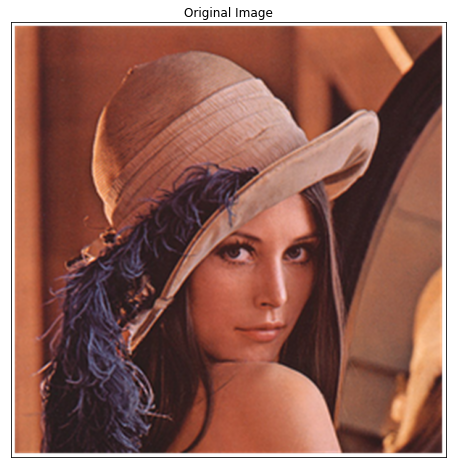

In [11]:
showImage(img, 'Original Image')

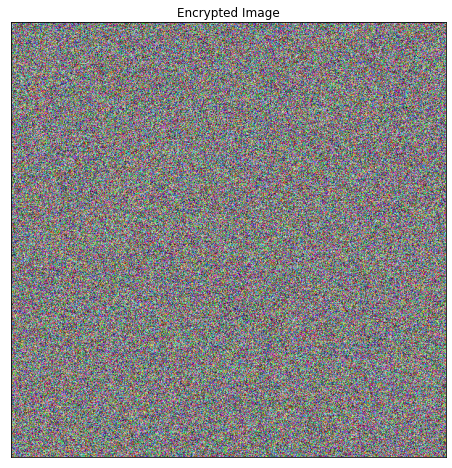

In [12]:
showImage(eImg, 'Encrypted Image')

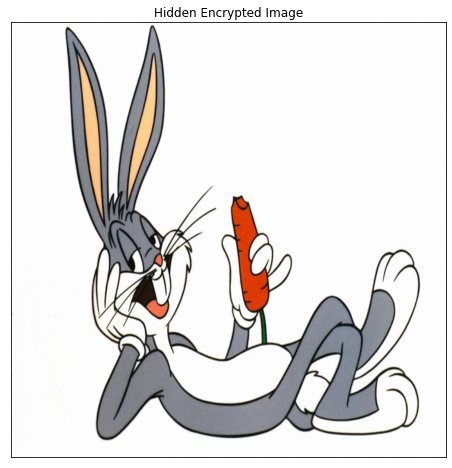

In [13]:
showImage(ehImg, 'Hidden Encrypted Image')

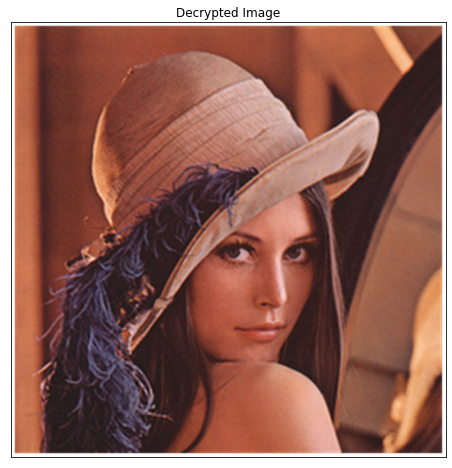

In [14]:
showImage(dImg, 'Decrypted Image')

In [15]:
# Difference between decrypted image and original image

np.unique(img-dImg)

array([0], dtype=uint8)

In [16]:
# Various tests

def plotHist(img, title = None):
    plt.figure(figsize=(14,5))
    plt.hist(img.flatten(), 256, [0,256])
    plt.title(title)
    plt.show()

def npcr(c1, c2):
    M, N = c1.shape
    return np.round((np.sum(c1!=c2))*100/(M*N), 7)

def uaci(c1,c2):
    M, N = c1.shape
    diff = (c1-c2)/255
    s = np.sum(diff)*100
    return np.round(s/(M*N*255), 7)

def correlation_coefficient(img):
    M, N = img.shape[0], img.shape[1]
    directions = [ [0,1],[1,0],[1,1]]
    corrRange = 10000
    ccfx = []
    for d in directions:
        pix = np.empty(corrRange)
        adj = np.empty(corrRange)
        for i in range(corrRange):
            rx = np.random.randint(0,M-1)
            ry = np.random.randint(0,N-1)
            pix[i] = img[rx][ry]
            adj[i] = img[rx+d[0]][ry+d[1]]
        a = pix - np.mean(pix)
        b = adj - np.mean(adj)
        num = np.sum(a*b)
        denm = np.sum(a**2) * np.sum(b**2)
        corr = num/np.sqrt(denm)
        corr = np.round(corr,7)
        ccfx.append(corr)
    return ccfx

def information_entropy(channel):
    M, N = channel.shape[0], channel.shape[1]
    fl = channel.flatten()
    bits = [0]*8
    for no in fl:
        binstr = format(no,'08b')
        for i in range(8):
            if binstr[i]=='1':
                bits[i]+=1
    ch = 1
    if(len(channel.shape)==3):
        ch = channel.shape[2]
    
    # print(np.array(bits)/(M*N*ch))
    ent= 0
    for i in range(8):
        pi = bits[i]/(M*N*ch)
        ent = ent - pi*np.log2(pi)

    # ent = -ent
    return ent

In [25]:
print("Entropy : ", information_entropy(eImg[:,:,2]))

Entropy :  3.9944069982512658


In [18]:
print("'''''''''''''''NPCR ANALYSIS''''''''''''''")
print( "R component " , npcr(img[:,:,0],eImg[:,:,0]))
print( "G component " , npcr(img[:,:,1],eImg[:,:,1]))
print( "B component " , npcr(img[:,:,2],eImg[:,:,2]))

'''''''''''''''NPCR ANALYSIS''''''''''''''
R component  99.6019444
G component  99.6038889
B component  99.5969444


In [19]:
print("'''''''UACI Analysis''''''''''''''''''")
print( "R component " , uaci(img[:,:,0],eImg[:,:,0]))
print( "G component " , uaci(img[:,:,1],eImg[:,:,1]))
print( "B component " , uaci(img[:,:,2],eImg[:,:,2]))

'''''''UACI Analysis''''''''''''''''''
R component  50.0529357
G component  50.2583388
B component  50.2587887


In [20]:
print("'''''''''''''''''''''''''CORRELATION ANALYSIS''''''''''''''''''''''")

print("***ORIGINAL IMAGE")
cfx_orig = correlation_coefficient(img[:,:,0])
print("R component  (Horiz , Vertical , Diagonal) => " , cfx_orig[0], cfx_orig[1], cfx_orig[2] )
cfx_orig = correlation_coefficient(img[:,:,1])
print("G component  (Horiz , Vertical , Diagonal) => " , cfx_orig[0], cfx_orig[1], cfx_orig[2] )
cfx_orig = correlation_coefficient(img[:,:,2])
print("B component  (Horiz , Vertical , Diagonal) => " , cfx_orig[0], cfx_orig[1], cfx_orig[2] )


print("****ENCRYPTED IMAGE****")
cfx_enc = correlation_coefficient(eImg[:,:,0])
print("R component  (Horiz , Vertical , Diagonal) => " , cfx_enc[0], cfx_enc[1], cfx_enc[2] )
cfx_enc = correlation_coefficient(eImg[:,:,1])
print("G component  (Horiz , Vertical , Diagonal) => " , cfx_enc[0], cfx_enc[1], cfx_enc[2] )
cfx_enc = correlation_coefficient(eImg[:,:,2])
print("B component  (Horiz , Vertical , Diagonal) => " , cfx_enc[0], cfx_enc[1], cfx_enc[2] )

'''''''''''''''''''''''''CORRELATION ANALYSIS''''''''''''''''''''''
***ORIGINAL IMAGE
R component  (Horiz , Vertical , Diagonal) =>  0.9910329 0.9914944 0.9809599
G component  (Horiz , Vertical , Diagonal) =>  0.9864968 0.9857786 0.9684284
B component  (Horiz , Vertical , Diagonal) =>  0.976998 0.9769772 0.9548956
****ENCRYPTED IMAGE****
R component  (Horiz , Vertical , Diagonal) =>  -0.0091406 0.0239787 0.0258514
G component  (Horiz , Vertical , Diagonal) =>  0.0058421 -0.0086878 -0.0031828
B component  (Horiz , Vertical , Diagonal) =>  -0.0032511 -0.0057096 -0.0125501


'''''''''''''''''''''''''Histogram ANALYSIS''''''''''''''''''''''
***ORIGINAL IMAGE


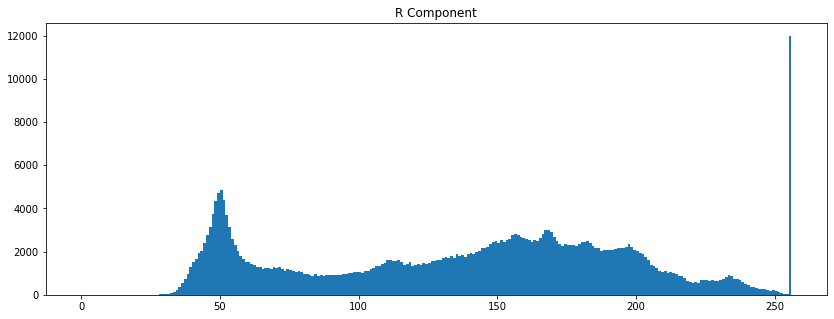

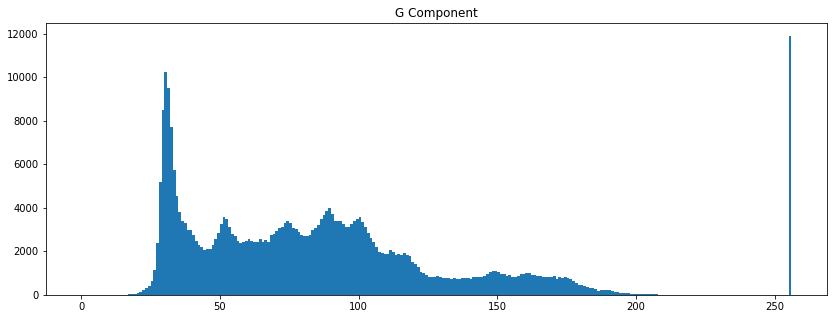

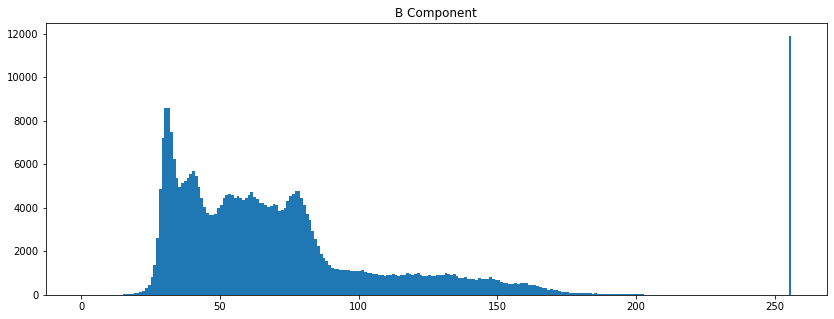

***ENCRYPTED IMAGE


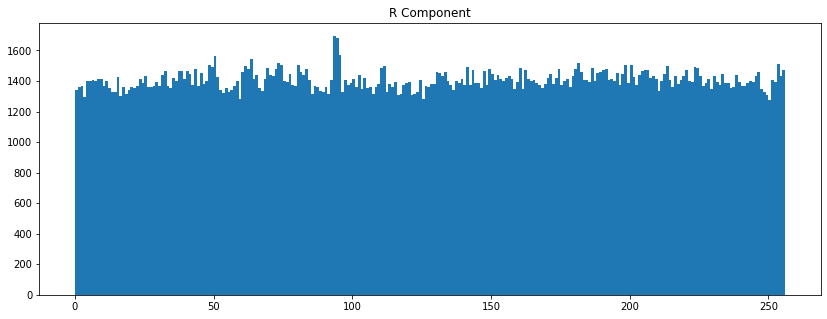

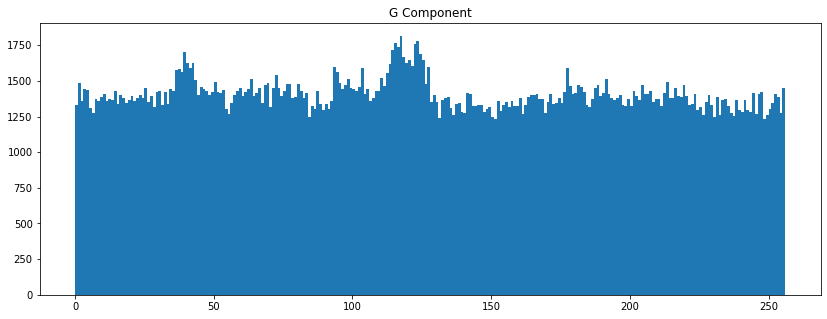

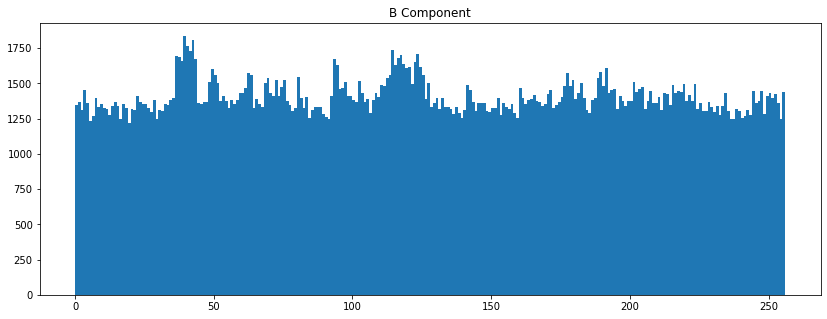

In [21]:
print("'''''''''''''''''''''''''Histogram ANALYSIS''''''''''''''''''''''")

print("***ORIGINAL IMAGE")
plotHist(img[:,:,0], 'R Component')
plotHist(img[:,:,1], 'G Component')
plotHist(img[:,:,2], 'B Component')

print("***ENCRYPTED IMAGE")
plotHist(eImg[:,:,0], 'R Component')
plotHist(eImg[:,:,1], 'G Component')
plotHist(eImg[:,:,2], 'B Component')